# Dataset Summary & A Few Anecdotes 


An NOAA dataset has been stored in the file `data/fb441e62df2d58994928907a91895ec62c2c42e6cd075c2700843b89.csv`. This is the dataset used in here. Note: The data for this notebook comes from a subset of The National Centers for Environmental Information (NCEI) [Daily Global Historical Climatology Network](https://www1.ncdc.noaa.gov/pub/data/ghcn/daily/readme.txt) (GHCN-Daily). The GHCN-Daily is comprised of daily climate records from thousands of land surface stations across the globe.

Each row in the datafile corresponds to a single observation.

The following variables provided:

* **id** : station identification code
* **date** : date in YYYY-MM-DD format (e.g. 2012-01-24 = January 24, 2012)
* **element** : indicator of element type
    * TMAX : Maximum temperature (tenths of degrees C)
    * TMIN : Minimum temperature (tenths of degrees C)
* **value** : data value for element (tenths of degrees C)

Tasks:

1. Familiarize with the dataset, write some python code which returns a line graph of the record high and record low temperatures by day of the year over the period 2005-2014. The area between the record high and record low temperatures for each day will be shaded.
2. To overlay a scatter of the 2015 data for any points (highs and lows) for which the ten year record (2005-2014) record high or record low was broken in 2015.

The data used here is near **Ann Arbor, Michigan, United States**

### Import Necessary Modules

In [43]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import mplleaflet
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")

### Plotting Source Stations on Map

In [44]:
df = pd.read_csv('../input/BinSize_d400.csv')
hashid = 'fb441e62df2d58994928907a91895ec62c2c42e6cd075c2700843b89'
station_locations_by_hash = df[df['hash'] == hashid]

lons = station_locations_by_hash['LONGITUDE'].tolist()
lats = station_locations_by_hash['LATITUDE'].tolist()

plt.figure(figsize=(8,8))

plt.scatter(lons, lats, c='r', alpha=0.7, s=200)

mplleaflet.display()

### Read data, parse dates, drop leap days, add day of year values and convert to degrees celcius

In [45]:
df = pd.read_csv('../input/fb441e62df2d58994928907a91895ec62c2c42e6cd075c2700843b89.csv', parse_dates=['Date'])
# Drop the data on 29th Februaries
df = df[(df['Date'].dt.month!=2) & (df['Date'].dt.day!=29)]
# Separate the days in a new column and sort in descending order by dates
df['dayofyear'] = df.Date.dt.dayofyear
df = df.sort_values('Date', ascending=False)
# Convert tenths of degrees celcius to degree celcius
df['Data_Value'] = df['Data_Value']/10
# See the changes
df.head()

,ID,Date,Element,Data_Value,dayofyear
37904,USW00014853,2015-12-31,TMAX,1.7,365
36836,USW00014833,2015-12-31,TMIN,-2.1,365
45691,USC00200032,2015-12-31,TMAX,1.1,365
45666,USC00200032,2015-12-31,TMIN,-3.3,365
29410,USC00200230,2015-12-31,TMIN,-1.7,365


### Dealing with mismatched day of year values

In [46]:
# Heres a problem - The Series.dt.dayofyear API assigns 61 to 1st March of leap years but 60 to 1st March of non-leap years
# Quick Check
print('For leap year 2008\n\n', df.loc[(df.Date=='2008-03-01')].head(1), '\n\n')
print('For non leap year 2007\n\n', df.loc[(df.Date=='2007-03-01')].head(1))

For leap year 2008

                  ID       Date Element  Data_Value  dayofyear
155086  USW00014833 2008-03-01    TMIN        -5.0         61 


For non leap year 2007

                 ID       Date Element  Data_Value  dayofyear
24520  USC00205050 2007-03-01    TMAX         3.9         60


In [47]:
# To resolve the issue 1 is subtracted from leap year day values starting from March
df.loc[((df['Date'].dt.is_leap_year==True) & (df['Date'].dt.month>2)), 'dayofyear'] = df['dayofyear']-1
df.loc[df.Date.dt.year == 2008, 'dayofyear']
# Quick check
print('For leap year 2008\n\n', df.loc[(df.Date=='2008-03-01')].head(1), '\n\n')
print('For non leap year 2007\n\n', df.loc[(df.Date=='2007-03-01')].head(1))

For leap year 2008

                  ID       Date Element  Data_Value  dayofyear
155086  USW00014833 2008-03-01    TMIN        -5.0         60 


For non leap year 2007

                 ID       Date Element  Data_Value  dayofyear
24520  USC00205050 2007-03-01    TMAX         3.9         60


### Only Keep the Highs and Lows accross all stations per Day of Year

In [48]:
# Separate the observations before 2015 and in 2015
df1 = df[df['Date']<'2015-1-1']
df2 = df[df['Date']>='2015-1-1']
# Get the maximum or minimum temparature values per day from the past data of 15 years
min_df = df1[df1['Element']=='TMIN'].groupby('dayofyear')['Data_Value'].min()
max_df = df1[df1['Element']=='TMAX'].groupby('dayofyear')['Data_Value'].max()
temp1 = pd.concat([max_df, min_df], axis=1)
temp1.reset_index(inplace=True)
temp1.columns=['Day', 'Max Temp(Past)', 'Min Temp(Past)']
temp1.head()

,Day,Max Temp(Past),Min Temp(Past)
0,1,15.6,-16.0
1,2,13.9,-26.7
2,3,13.3,-26.7
3,4,10.6,-26.1
4,5,12.8,-15.0


In [49]:
# Similarly Get the maximum or minimum temparature values per day from 2015
min_df = df2[df2['Element']=='TMIN'].groupby('dayofyear')['Data_Value'].min()
max_df = df2[df2['Element']=='TMAX'].groupby('dayofyear')['Data_Value'].max()
temp2 = pd.concat([max_df, min_df], axis=1)
temp2.reset_index(inplace=True)
temp2.columns=['Day', 'Max Temp(2015)', 'Min Temp(2015)']
# join them
temp = pd.merge(temp1, temp2, how='outer', on='Day')
# Check the table
temp.head()

,Day,Max Temp(Past),Min Temp(Past),Max Temp(2015),Min Temp(2015)
0,1,15.6,-16.0,1.1,-13.3
1,2,13.9,-26.7,3.9,-12.2
2,3,13.3,-26.7,3.9,-6.7
3,4,10.6,-26.1,4.4,-8.8
4,5,12.8,-15.0,2.8,-15.5


### Only Keep the Record Breaking Temperature Values in 2015

In [50]:
# Only the temperature in 2015 which broke past records is to be kept-
temp['Max Temp(2015)'].where((temp['Max Temp(2015)']>temp['Max Temp(Past)']), inplace=True)
temp['Min Temp(2015)'].where((temp['Min Temp(2015)']<temp['Min Temp(Past)']), inplace=True)
# Quick Check
temp.tail(10)

,Day,Max Temp(Past),Min Temp(Past),Max Temp(2015),Min Temp(2015)
316,355,15.6,-19.4,NaN,NaN
317,356,13.3,-20.0,NaN,NaN
318,357,13.3,-20.0,18.3,NaN
319,358,13.9,-16.7,17.2,NaN
320,359,10.0,-16.7,11.1,NaN
321,360,10.6,-15.6,11.7,NaN
322,361,18.9,-13.8,NaN,NaN
323,362,19.4,-16.6,NaN,NaN
324,364,11.7,-14.4,NaN,NaN
325,365,13.9,-15.0,NaN,NaN


### Time Series Plot of Weather Patterns

<Figure size 432x288 with 0 Axes>

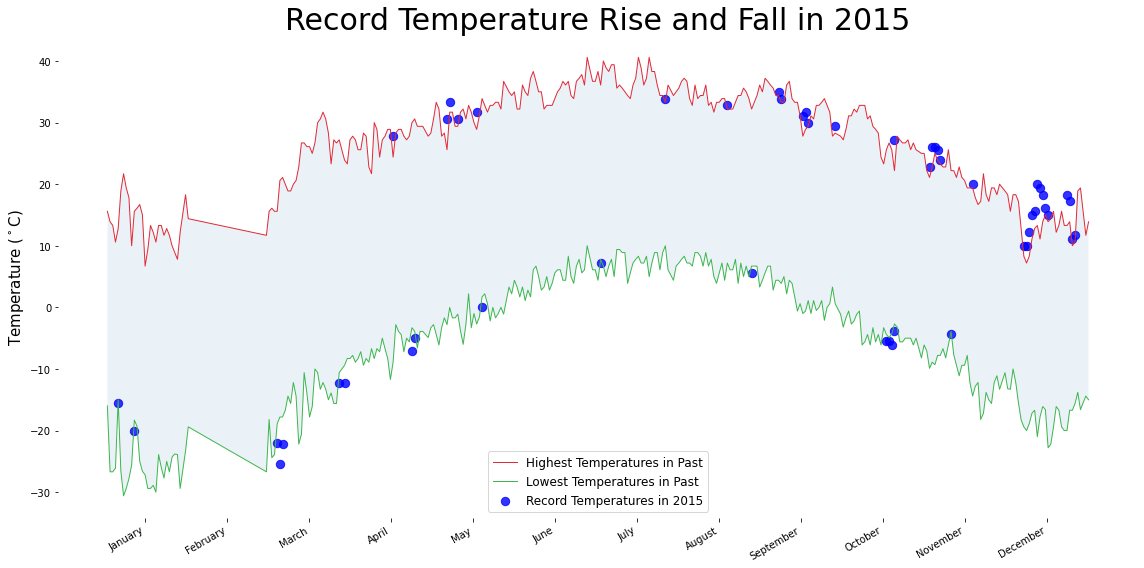

In [51]:
plt.clf()
plt.figure(figsize=(16,8))
plt.plot('Day', 'Max Temp(Past)', data=temp, markersize=2, linewidth=1, c='#E12B38', alpha=1, label='Highest Temperatures in Past')
plt.plot('Day', 'Min Temp(Past)', data=temp, markersize=2, linewidth=1, c='#3EB650', alpha=1, label='Lowest Temperatures in Past')
plt.fill_between(temp['Day'], temp['Max Temp(Past)'], temp['Min Temp(Past)'], interpolate=True, alpha=0.09)
plt.scatter('Day', 'Max Temp(2015)', data=temp, c='b', s=70, label='Record Temperatures in 2015', alpha=0.8)
plt.scatter('Day', 'Min Temp(2015)', data=temp, c='b', s=70, label=None, alpha=0.8)
plt.title('Record Temperature Rise and Fall in 2015', fontsize=30)
plt.ylabel('Temperature ($^\circ$C)', fontsize=15)
for spine in plt.gca().spines.values():
    spine.set_visible(False)
plt.xticks(np.linspace(15,380,13)[:-1], ('January', 'February', 'March', 'April', 'May', 'June', 'July', 'August',
                                         'September', 'October', 'November', 'December'))
plt.gcf().autofmt_xdate()
plt.tight_layout()
plt.legend(loc=8, fontsize=12)
# In case it is required to save, capture the figure object
fig1 = plt.gcf()
plt.show()

### Save Figure

In [52]:
fig1.savefig('weather_pattern2015.png', dpi=300)